In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels import PanelOLS
import plotly.express as px

sns.set_theme()

# Functions

In [2]:
def Pivoting(df): # Function to pivot the dataframe
    df_r = df.pivot(index=['CCode','year'], 
                       columns='indicator', 
                       values='value')
    df_r.reset_index(inplace=True)
    df_r.columns.name = None
    return df_r

In [3]:
def PrepareData(df,ind): # Function to prepare the data for analysis
    Panel = df.copy()
    shift = ind.replace('_value', '') + '_shifted'
    Panel[shift] = Panel.groupby('CCode')[ind].shift(1)
    Panel[shift].dropna(inplace=True) # Drop rows with NaN values
    return Panel

In [4]:
def Regression(Panel,independent_vars,dependent_var): # Function to run the regression
    L = ['CCode','year']
    L.extend(independent_vars)
    L.append(dependent_var)
    model_df = Panel[L].copy()
    model_df = model_df.set_index(['CCode', 'year'])
    model_df = model_df.dropna() # Drop rows with NaN values

    Y = model_df[dependent_var]
    X = model_df[independent_vars]
    X = sm.add_constant(X)

    mod_fe = PanelOLS(Y,X, entity_effects=True, time_effects=True)
    results = mod_fe.fit(cov_type='clustered',cluster_entity=True)

    print(results.summary)
    return None

# Data loading and preparation

## Data loading

In [5]:
path = 'Datasets/' # To be changed if needed

GDP per capita dataset source: https://data.worldbank.org/indicator/NY.GDP.PCAP.CD

In [8]:
# gdp_pc = pd.read_csv(path+'GDP-PC.csv',skiprows=4) # Upload the GDP per capita data
gdp_pc = pd.read_csv(path+'WB_WDI_NY_GDP_PCAP_PP_CD.csv')

HDR dataset source: https://hdr.undp.org/data-center/documentation-and-downloads

In [9]:
hdr = pd.read_excel(path+'hdr-data.xlsx') # Upload the HDR data
hdr.isnull().sum() # Check for missing values

countryIsoCode         0
country                0
indexCode              0
index                  0
dimension         186115
indicatorCode          0
indicator              0
year                   7
value                  0
note              185973
dtype: int64

Schooling dataset source: https://databrowser.uis.unesco.org/resources

In [10]:
schooling = pd.read_csv(path+'OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Upload the schooling data
schooling_labels = pd.read_csv(path+'OPRI_LABEL.csv') # Upload the schooling labels

/var/folders/pl/qxmk8x1d1m586z4_j013bvqw0000gn/T/ipykernel_8198/3372200621.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  schooling = pd.read_csv(path+'OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Upload the schooling data


In [11]:
Labels = schooling_labels.iloc[0:18,0] # Get the labels for the schooling data
SCH = schooling.copy()
SCH = SCH[SCH['INDICATOR_ID'].isin(Labels)]
SCH = SCH.drop(columns=['MAGNITUDE','QUALIFIER'])
SCH = pd.merge(schooling_labels,SCH,how='left',on='INDICATOR_ID') # Merge the labels with the schooling data
SCH = SCH.rename(columns={'INDICATOR_LABEL_EN': 'indicator', 'COUNTRY_ID': 'CCode', 'YEAR': 'year', 'VALUE': 'value'}) # Rename the columns
SCH['year'] = pd.to_datetime(SCH['year'], format='%Y',errors='coerce').dt.year 

In [12]:
Countries = {hdr['countryIsoCode'][i]:hdr['country'][i] for i in range(len(hdr))} # Create a dictionary to map country codes to country names

In [13]:
HDR = hdr.copy().drop(columns=['dimension','note','country']) # Drop unnecessary columns
HDR['year'] = pd.to_datetime(HDR['year'], format='%Y',errors='coerce').dt.year # Convert year to datetime format
HDR.rename(columns={'countryIsoCode':'CCode'},inplace=True) # Rename columns for consistency

In [14]:
'''
Since the HDR data contains multiple indices, we need to separate them into different dataframes.
We will create a dictionary to store these dataframes, where the keys are the index codes and the values are the corresponding dataframes.
'''
indecies = HDR['indexCode'].unique() # Get unique Country codes
grouped_dfs = {} # Create a dictionary to store dataframes for each index

for code in indecies:
    grouped_dfs[code] = HDR[HDR['indexCode'] == code].drop(columns=['indexCode', 'index']) # Drop unnecessary columns

GII = grouped_dfs.get('GII') # Get the GII dataframe
HDI = grouped_dfs.get('HDI') # Get the HDI dataframe
GDI = grouped_dfs.get('GDI') # Get the GDI dataframe
IHDI = grouped_dfs.get('IHDI') # Get the IHDI dataframe
PHDI = grouped_dfs.get('PHDI') # Get the PHDI dataframe
MPI = grouped_dfs.get('MPI') # Get the MPI dataframe

## Pivoting

#### GII

GII explanation: https://hdr.undp.org/data-center/thematic-composite-indices/gender-inequality-index#/indicies/GII  

GII reflects gender-based disadvantage in three dimensions— reproductive health, empowerment and the labour market—for as many countries as data of reasonable quality allow. It shows the loss in potential human development due to inequality between female and male achievements in these dimensions. It ranges from 0, where women and men fare equally, to 1, where one gender fares as poorly as possible in all measured dimensions. GII values are computed using the association-sensitive inequality measure suggested by Seth (2009), which implies that the index is based on the general mean of general means of different orders—the first aggregation is by a geometric mean across dimensions; these means, calculated separately for women and men, are then aggregated using a harmonic mean across genders.

In [15]:
GII_r = Pivoting(GII) # Pivot the GII dataframe
GII_r.drop(columns=['GII Rank'],inplace=True) # Drop the GII Rank column
col_to_move = GII_r.pop('Gender Inequality Index (value)')
GII_r.insert(3, 'GII_value', col_to_move) # Move the GII value column to the 3rd position
GII_r

,CCode,year,"Adolescent Birth Rate (births per 1,000 women ages 15-19)",GII_value,"Labour force participation rate, female (% ages 15 and older)","Labour force participation rate, male (% ages 15 and older)","Maternal Mortality Ratio (deaths per 100,000 live births)","Population with at least some secondary education, female (% ages 25 and older)","Population with at least some secondary education, male (% ages 25 and older)","Share of seats in parliament, female (% held by women)","Share of seats in parliament, male (% held by men)"
0,AFG,1990.0,142.960,NaN,NaN,NaN,1377.859,1.108,7.899,NaN,NaN
1,AFG,1991.0,147.525,NaN,NaN,NaN,1392.786,1.221,8.138,NaN,NaN
2,AFG,1992.0,147.521,NaN,NaN,NaN,1451.594,1.335,8.377,NaN,NaN
3,AFG,1993.0,147.896,NaN,NaN,NaN,1368.816,1.449,8.616,NaN,NaN
4,AFG,1994.0,155.669,NaN,NaN,NaN,1375.091,1.562,8.855,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6801,ZZM.LDC,2022.0,92.400,0.556,50.4,75.5,NaN,23.400,33.800,25.1,NaN
6802,ZZN.SIDS,2020.0,NaN,NaN,NaN,NaN,203.000,NaN,NaN,NaN,NaN
6803,ZZN.SIDS,2022.0,50.600,0.457,51.4,69.8,NaN,58.800,62.300,27.0,NaN
6804,ZZO.OECD,2020.0,NaN,NaN,NaN,NaN,21.000,NaN,NaN,NaN,NaN


It will be useful later to have Countries grouped in categeories for data exploration. With this aim, GII will be splitted in 4 categories, based on its quartile.
* $GII\ge q_{0.75}$: not-balanced country
* $GII\in[q_{0.5},q_{0.75})$: medium-balanced country
* $GII\in[q_{0.5},q_{0.75})$: balanced country
* $GII < q_{0.25}$: very-balanced country

In [16]:
GII_r['GII_Category'] = pd.qcut(GII_r['GII_value'], q=4, labels=['VB', 'B', 'MB', 'NB'])

#### GDI

GDI explanation: https://hdr.undp.org/gender-development-index#/indicies/GDI  

GDI measures gender inequalities in achievement in three basic dimensions of human development: health, measured by female and male life expectancy at birth; education, measured by female and male expected years of schooling for children and female and male mean years of schooling for adults ages 25 years and older; and command over economic resources, measured by female and male estimated earned income.

In [17]:
GDI_r = Pivoting(GDI) # Pivot the GDI dataframe
col_to_move = GDI_r.pop('Gender Development Index (value)') # Move the GDI value column to the 3rd position
GDI_r.insert(3, 'GDI_value', col_to_move)
col_to_move = GDI_r.pop('GDI Group') # Move the GDI Group column to the 4th position
GDI_r.insert(4, 'GDI Group', col_to_move)
GDI_r

,CCode,year,"Expected Years of Schooling, female (years)",GDI_value,GDI Group,"Expected Years of Schooling, male (years)","Gross National Income Per Capita, female (2017 PPP$)","Gross National Income Per Capita, male (2017 PPP$)",HDI female,HDI male,"Life Expectancy at Birth, female (years)","Life Expectancy at Birth, male (years)","Mean Years of Schooling, female (years)","Mean Years of Schooling, male (years)"
0,AFG,1990.0,2.117,NaN,NaN,4.533,NaN,NaN,NaN,NaN,48.397,43.709,0.202,1.494
1,AFG,1991.0,2.246,NaN,NaN,4.768,NaN,NaN,NaN,NaN,49.144,44.353,0.219,1.579
2,AFG,1992.0,2.383,NaN,NaN,5.016,NaN,NaN,NaN,NaN,50.320,45.070,0.236,1.664
3,AFG,1993.0,2.528,NaN,NaN,5.277,NaN,NaN,NaN,NaN,52.739,50.216,0.254,1.749
4,AFG,1994.0,2.682,NaN,NaN,5.551,NaN,NaN,NaN,NaN,53.544,49.531,0.271,1.833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,ZZK.WORLD,2022.0,13.082,0.951,NaN,12.908,12515.518,22034.766,0.719,0.756,74.532,69.599,8.231,9.118
6798,ZZL.DC,2022.0,12.600,0.929,NaN,12.500,7283.000,14943.000,0.716,0.665,72.900,68.200,7.100,8.200
6799,ZZM.LDC,2022.0,9.900,0.890,NaN,10.300,2042.000,4054.000,0.509,0.572,67.400,62.500,4.300,5.900
6800,ZZN.SIDS,2022.0,12.900,0.979,NaN,12.300,13079.000,19712.000,0.722,0.738,74.300,69.000,8.500,8.800


#### HDI

HDI explanation: https://hdr.undp.org/data-center/human-development-index#/indicies/HDI  


The Human Development Index (HDI) is a summary measure of average achievement in key dimensions of human development: a long and healthy life, being knowledgeable and having a decent standard of living. The HDI is the geometric mean of normalized indices for each of the three dimensions.

The health dimension is assessed by life expectancy at birth, the education dimension is measured by mean of years of schooling for adults aged 25 years and more and expected years of schooling for children of school entering age. The standard of living dimension is measured by gross national income per capita. The HDI uses the logarithm of income, to reflect the diminishing importance of income with increasing GNI. The scores for the three HDI dimension indices are then aggregated into a composite index using geometric mean. Refer to Technical notes for more details.

In [18]:
HDI_r = Pivoting(HDI)
HDI_r.drop(columns=['HDI Rank'],inplace=True)
col_to_move = HDI_r.pop('Human Development Index (value)')
HDI_r.insert(3, 'HDI_value', col_to_move)
HDI_r

,CCode,year,Expected Years of Schooling (years),HDI_value,Gross National Income Per Capita (2017 PPP$),Life Expectancy at Birth (years),Mean Years of Schooling (years)
0,AFG,1990.0,2.936,0.284,3115.670,45.967,0.872
1,AFG,1991.0,3.228,0.292,2817.305,46.663,0.915
2,AFG,1992.0,3.520,0.299,2474.682,47.596,0.959
3,AFG,1993.0,3.812,0.307,1723.020,51.466,1.002
4,AFG,1994.0,4.104,0.300,1202.010,51.495,1.045
...,...,...,...,...,...,...,...
6825,ZZO.OECD,2015.0,NaN,0.894,NaN,NaN,NaN
6826,ZZO.OECD,2019.0,NaN,0.905,NaN,NaN,NaN
6827,ZZO.OECD,2020.0,NaN,0.897,NaN,NaN,NaN
6828,ZZO.OECD,2021.0,NaN,0.899,NaN,NaN,NaN


Countries can be divided in 4 categories: Very high human development (>0.8), High human development (0.700-0.799), Medium human development (0.550-0.699), Low human development (<0.550). https://hdr.undp.org/sites/default/files/2023-24_HDR/hdr2023-24_technical_notes.pdf  

In [19]:
bins = [0, 0.55, 0.7, 0.8, 1]
labels = ['L', 'M', 'H', 'VH']

HDI_r['HDI_Category'] = pd.cut(HDI_r['HDI_value'], bins=bins, labels=labels, include_lowest=True)

#### IHDI

IHDI explanation: https://hdr.undp.org/inequality-adjusted-human-development-index#/indicies/IHDI  

IHDI is based on a distribution-sensitive class of composite indices proposed by Foster, Lopez-Calva and Szekely (2005), which draws on the Atkinson (1970) family of inequality measures. It is computed as a geometric mean of inequality-adjusted dimensional indices. The IHDI accounts for inequalities in HDI dimensions by “discounting” each dimension’s average value according to its level of inequality. The IHDI value equals the HDI value when there is no inequality across people but falls below the HDI value as inequality rises. In this sense, the IHDI measures the level of human development when inequality is accounted for.

In [20]:
IHDI_r = Pivoting(IHDI)
col_to_move = IHDI_r.pop('Inequality-adjusted Human Development Index (value)')
IHDI_r.insert(3, 'IHDI_value', col_to_move)
IHDI_r

,CCode,year,Coefficient of human inequality,IHDI_value,Inequality in eduation,Inequality in income,Inequality in life expectancy,Overall loss (%)
0,AFG,2010.0,35.768,0.287,44.823,28.638,33.842,36.080
1,AFG,2011.0,35.453,0.293,44.823,28.638,32.897,35.886
2,AFG,2012.0,34.755,0.302,44.823,27.406,32.036,35.332
3,AFG,2013.0,34.478,0.309,44.823,27.406,31.204,34.947
4,AFG,2014.0,34.322,0.313,44.823,27.406,30.736,34.792
...,...,...,...,...,...,...,...,...
2677,ZZK.WORLD,2022.0,21.732,0.576,21.725,30.330,13.141,22.057
2678,ZZL.DC,2022.0,24.200,0.524,25.000,32.500,14.900,NaN
2679,ZZM.LDC,2022.0,32.700,0.363,36.200,38.600,23.400,NaN
2680,ZZN.SIDS,2022.0,23.200,0.558,22.000,32.700,14.900,NaN


#### GDP per capita

In [23]:
gdp_pc

,STRUCTURE,STRUCTURE_ID,ACTION,FREQ_ID,FREQ_NAME,REF_AREA_ID,REF_AREA_NAME,INDICATOR_ID,INDICATOR_NAME,SEX_ID,...,DATA_SOURCE_NAME,UNIT_TYPE_ID,UNIT_TYPE_NAME,TIME_FORMAT_ID,TIME_FORMAT_NAME,COMMENT_OBS,OBS_STATUS_ID,OBS_STATUS_NAME,OBS_CONF_ID,OBS_CONF_NAME
0,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,AFE,Africa Eastern and Southern,WB_WDI_NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",_T,...,World Development Indicators (WDI),CUR,Currency,P1Y,Annual,NaN,A,Normal value,PU,Public
1,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,AFW,Africa Western and Central,WB_WDI_NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",_T,...,World Development Indicators (WDI),CUR,Currency,P1Y,Annual,NaN,A,Normal value,PU,Public
2,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,ARB,Arab World,WB_WDI_NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",_T,...,World Development Indicators (WDI),CUR,Currency,P1Y,Annual,NaN,A,Normal value,PU,Public
3,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,CSS,Caribbean small states,WB_WDI_NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",_T,...,World Development Indicators (WDI),CUR,Currency,P1Y,Annual,NaN,A,Normal value,PU,Public
4,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,CEB,Central Electricity Board (CEB),WB_WDI_NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",_T,...,World Development Indicators (WDI),CUR,Currency,P1Y,Annual,NaN,A,Normal value,PU,Public
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8261,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,VUT,Vanuatu,WB_WDI_NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",_T,...,World Development Indicators (WDI),CUR,Currency,P1Y,Annual,NaN,A,Normal value,PU,Public
8262,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,VNM,Viet Nam,WB_WDI_NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",_T,...,World Development Indicators (WDI),CUR,Currency,P1Y,Annual,NaN,A,Normal value,PU,Public
8263,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,PSE,West Bank and Gaza,WB_WDI_NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",_T,...,World Development Indicators (WDI),CUR,Currency,P1Y,Annual,NaN,A,Normal value,PU,Public
8264,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,ZMB,Zambia,WB_WDI_NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",_T,...,World Development Indicators (WDI),CUR,Currency,P1Y,Annual,NaN,A,Normal value,PU,Public


In [24]:
GDP_PC = gdp_pc.copy()
GDP_PC = GDP_PC[['REF_AREA_ID','INDICATOR_NAME','TIME_PERIOD','OBS_VALUE']]
GDP_PC.rename(columns={'REF_AREA_ID':'CCode','INDICATOR_NAME':'indicator','TIME_PERIOD':'year','OBS_VALUE':'GDP_PC_value'},inplace=True) # Rename columns for consistency
GDP_PC['year'] = pd.to_datetime(GDP_PC['year'], format='%Y',errors='coerce').dt.year
GDP_PC['logGDP'] = np.log(GDP_PC['GDP_PC_value'])

### Schooling

In [ ]:
SCH_r = Pivoting(SCH) # Pivot the dataframe

In [ ]:
SCH_r.columns

Index(['CCode', 'year', 'Adult illiterate population, 15+ years, % female',
       'Adult illiterate population, 15+ years, both sexes (number)',
       'Adult illiterate population, 15+ years, female (number)',
       'Adult illiterate population, 15+ years, male (number)',
       'Adult illiterate population, 15+ years, rural, % female',
       'Adult illiterate population, 15+ years, rural, both sexes (number)',
       'Adult illiterate population, 15+ years, rural, female (number)',
       'Adult illiterate population, 15+ years, rural, male (number)',
       ...
       'Total net enrolment rate, primary, male (%)',
       'Total net enrolment rate, upper secondary, adjusted gender parity index (GPIA)',
       'Total net enrolment rate, upper secondary, both sexes (%)',
       'Total net enrolment rate, upper secondary, female (%)',
       'Total net enrolment rate, upper secondary, male (%)',
       'Total outbound internationally mobile tertiary students studying abroad, all coun

## Merged Datasets

#### GDP per capita & GII

In [25]:
GDP_PC_GII = pd.merge(
    GDP_PC, GII_r,
    on=["CCode", "year"], 
    how="inner"
)
GDP_PC_GII.columns.name = None

#### GDP per capita & GDI

In [26]:
GDP_PC_GDI = pd.merge(  
    GDP_PC, GDI_r,
    on=["CCode", "year"], 
    how="inner"
)
GDP_PC_GDI.columns.name = None

#### GDP per capita & HDI

In [27]:
GDP_PC_HDI = pd.merge(  
    GDP_PC, HDI_r,
    on=["CCode", "year"], 
    how="inner"
)
GDP_PC_HDI.columns.name = None

#### GDP per capita & IDHI

In [28]:
GDP_PC_IHDI = pd.merge(  
    GDP_PC, IHDI_r,
    on=["CCode", "year"], 
    how="inner"
)
GDP_PC_IHDI.columns.name = None

#### Indexes

In [29]:
gii_r = GII_r[['CCode','year','GII_value','GII_Category']]
gdi_r = GDI_r[['CCode','year','GDI_value','GDI Group']]
hdi_r = HDI_r[['CCode','year','HDI_value','HDI_Category']]
ihdi_r = IHDI_r[['CCode','year','IHDI_value']]

IDX = pd.merge(
    GDP_PC, gii_r,
    on=["CCode", "year"], 
    how="outer"
)
IDX = pd.merge(
    IDX, gdi_r,
    on=["CCode", "year"], 
    how="outer"
)
IDX = pd.merge(
    IDX, hdi_r,
    on=["CCode", "year"], 
    how="outer"
)
IDX = pd.merge(
    IDX, ihdi_r,
    on=["CCode", "year"], 
    how="outer"
)

In [30]:
IDX = IDX[IDX['year']>=GII_r['year'].min()]
IDX = IDX[IDX['year']<=GII_r['year'].max()]

# Data visualization

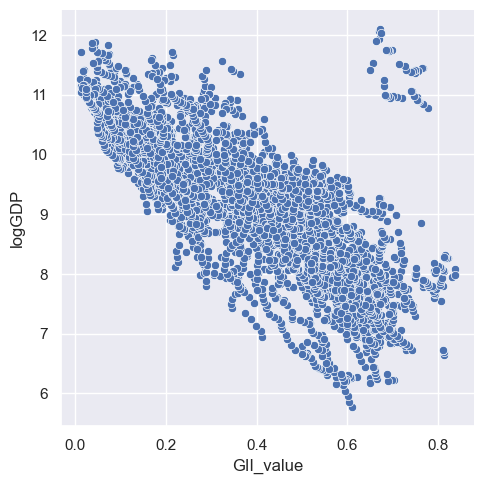

In [31]:
sns.relplot(
    data=IDX, kind="scatter",
    y="logGDP", x='GII_value',
    facet_kws=dict(sharex=False),
)
plt.show()

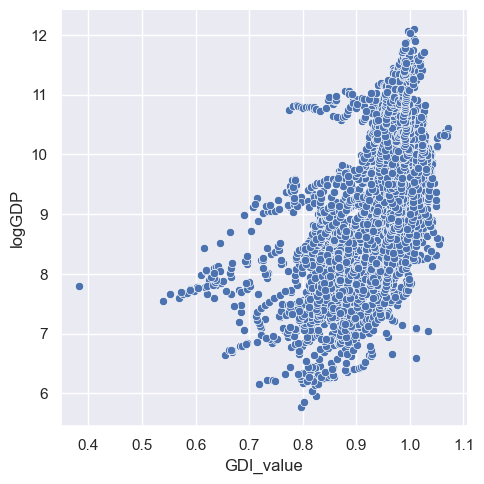

In [32]:
sns.relplot(
    data=IDX, kind="scatter",
    y="logGDP", x='GDI_value',
    facet_kws=dict(sharex=False),
)
plt.show()

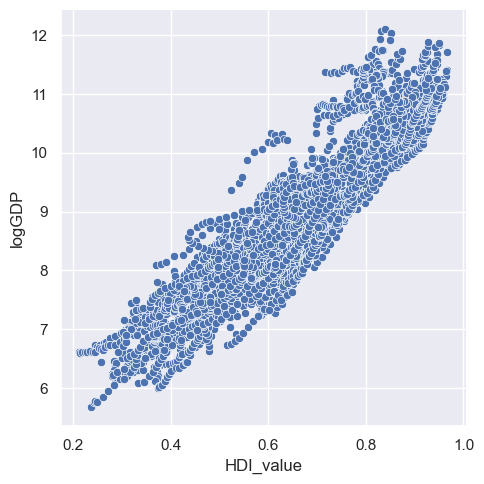

In [33]:
sns.relplot(
    data=IDX, kind="scatter",
    y="logGDP", x='HDI_value',
    facet_kws=dict(sharex=False),
)
plt.show()

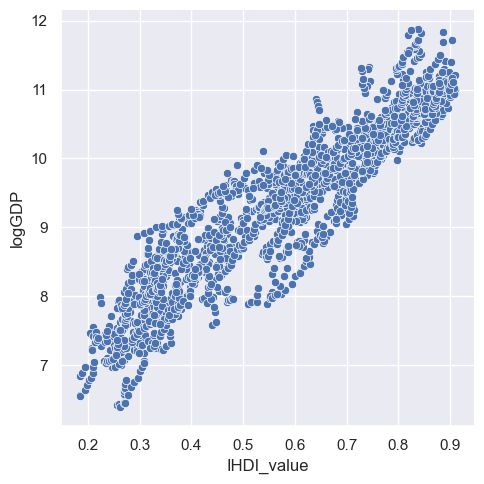

In [34]:
sns.relplot(
    data=IDX, kind="scatter",
    y="logGDP", x='IHDI_value',
    facet_kws=dict(sharex=False),
)
plt.show()

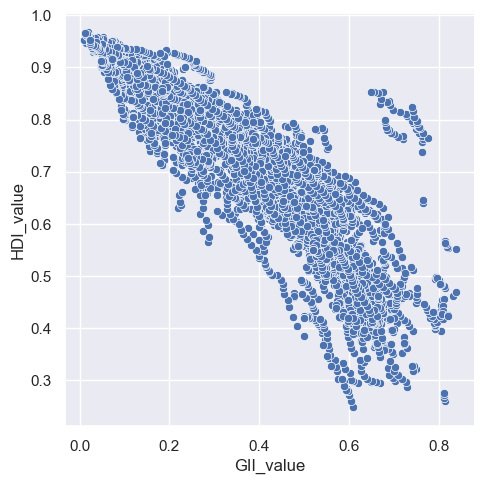

In [35]:
sns.relplot(
    data=IDX, kind="scatter",
    y="HDI_value", x='GII_value',
    facet_kws=dict(sharex=False),
)
plt.show()

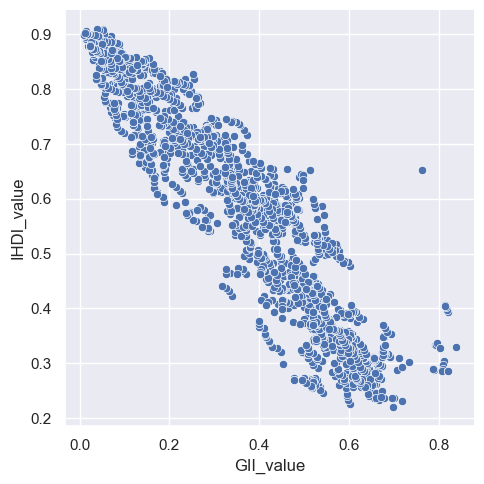

In [36]:
sns.relplot(
    data=IDX, kind="scatter",
    y="IHDI_value", x='GII_value',
    facet_kws=dict(sharex=False),
)
plt.show()

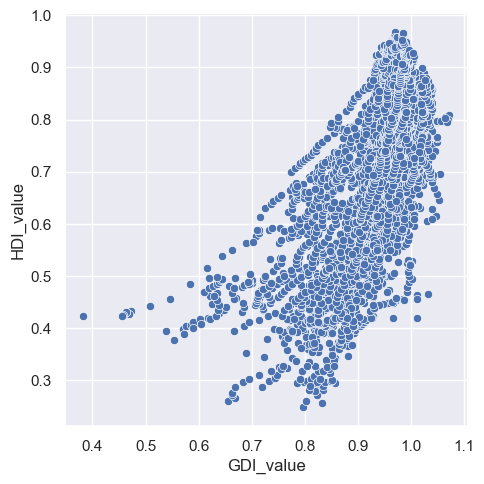

In [37]:
sns.relplot(
    data=IDX, kind="scatter",
    y="HDI_value", x='GDI_value',
    facet_kws=dict(sharex=False),
)
plt.show()

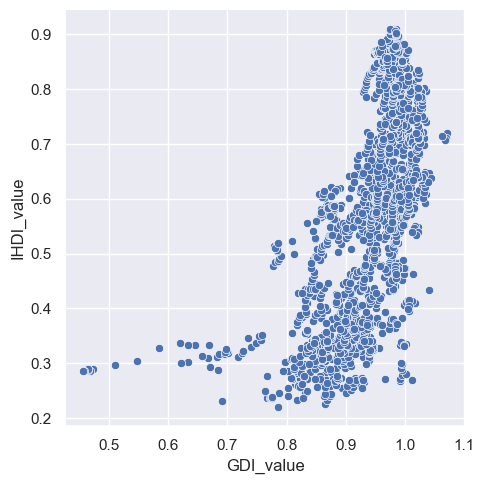

In [38]:
sns.relplot(
    data=IDX, kind="scatter",
    y="IHDI_value", x='GDI_value',
    facet_kws=dict(sharex=False),
)
plt.show()

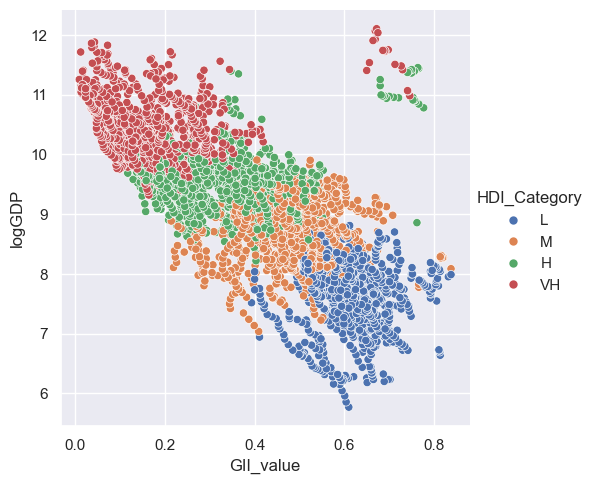

In [39]:
sns.relplot(
    data=IDX, kind="scatter",
    y="logGDP", x='GII_value', hue='HDI_Category',
    facet_kws=dict(sharex=False),
)
plt.show()

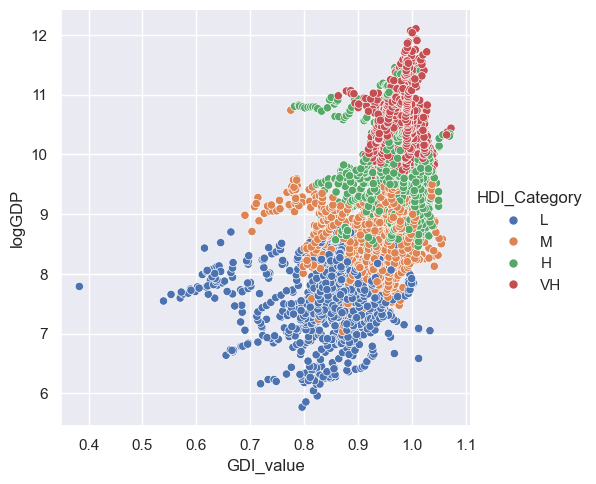

In [40]:
sns.relplot(
    data=IDX, kind="scatter",
    y="logGDP", x='GDI_value', hue='HDI_Category',
    facet_kws=dict(sharex=False),
)
plt.show()

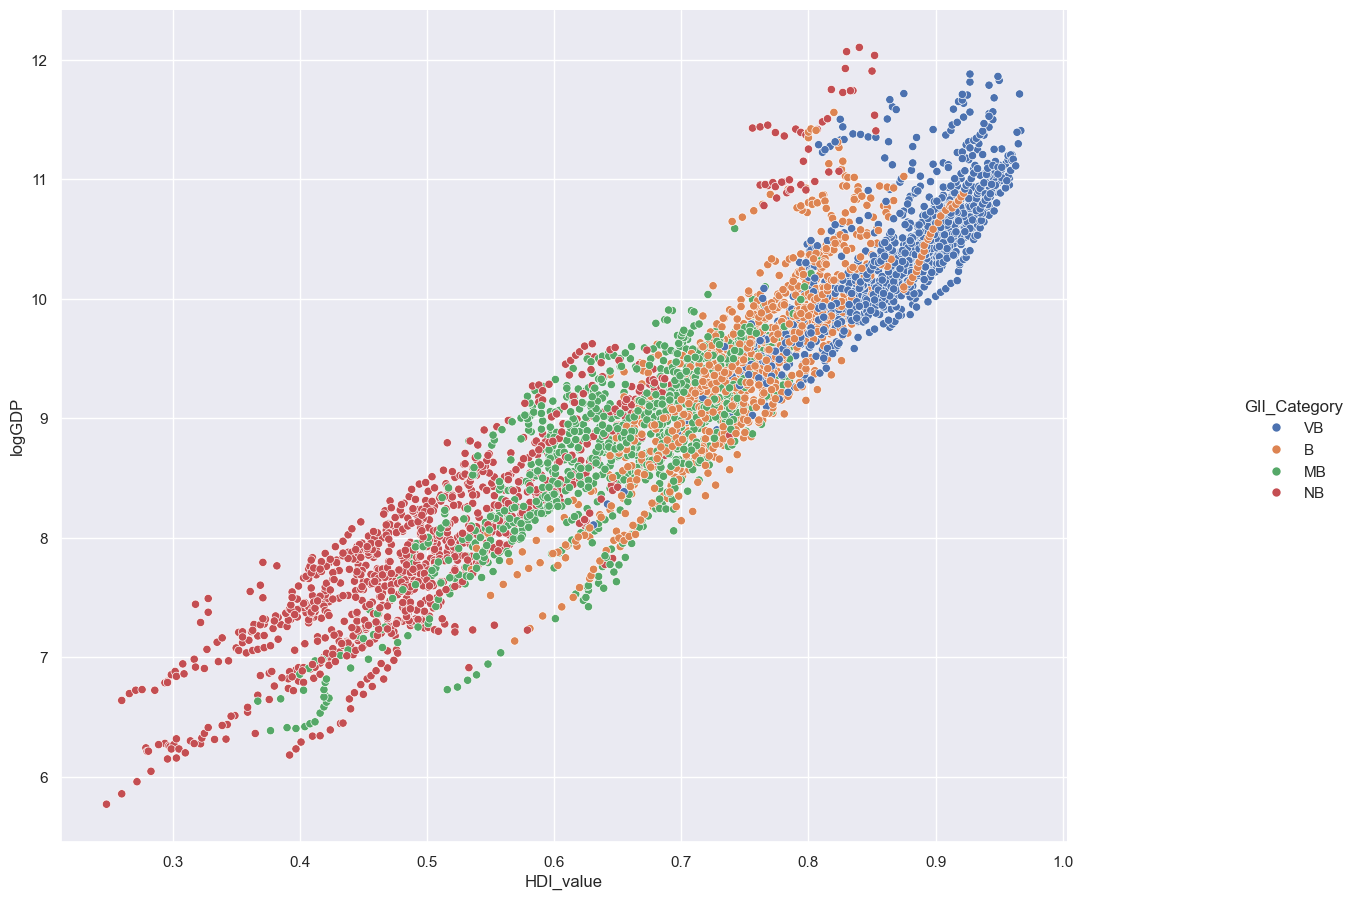

In [41]:
g = sns.relplot(
    data=IDX, kind="scatter",
    y="logGDP", x='HDI_value', hue='GII_Category',
    facet_kws=dict(sharex=False),
)
g.figure.set_size_inches(15, 10)
plt.show()

# Correlation

In [42]:
Matrix = IDX[['logGDP', 'GII_value','GDI_value', 'HDI_value', 'IHDI_value']]
Matrix = Matrix.corr(method='pearson').abs()
np.fill_diagonal(Matrix.values, np.nan)
Matrix.style.background_gradient(cmap='coolwarm', axis=None, gmap=Matrix)

,logGDP,GII_value,GDI_value,HDI_value,IHDI_value
logGDP,nan,0.772506,0.573957,0.927625,0.931200
GII_value,0.772506,nan,0.674845,0.878791,0.933778
GDI_value,0.573957,0.674845,nan,0.673159,0.625000
HDI_value,0.927625,0.878791,0.673159,nan,0.983391
IHDI_value,0.931200,0.933778,0.625000,0.983391,nan


# Regression

In [43]:
Panel_GII = PrepareData(GDP_PC_GII,'GII_value') # Prepare the GII data
Panel_GDI = PrepareData(GDP_PC_GDI,'GDI_value') # Prepare the GDI data
Panel_HDI = PrepareData(GDP_PC_HDI,'HDI_value') # Prepare the HDI data
Panel_IHDI = PrepareData(GDP_PC_IHDI,'IHDI_value') # Prepare the IHDI data

In [44]:
indecies = ['GII_value', 'GDI_value', 'HDI_value', 'IHDI_value']
Panel_IDX = IDX.copy()

for ind in indecies:
    shift = ind.replace('_value', '') + '_shifted'
    Panel_IDX[shift] = Panel_IDX.groupby('CCode')[ind].shift(1) # Shift the values by 1 year


### $\log(GDP_{pc,t})=\alpha+\beta+\gamma GII_{t-1}+\epsilon$

In [45]:
Regression(Panel_GII, independent_vars = ['GII_shifted'], dependent_var = 'logGDP')

                          PanelOLS Estimation Summary                           
Dep. Variable:                 logGDP   R-squared:                        0.0011
Estimator:                   PanelOLS   R-squared (Between):             -0.0433
No. Observations:                4174   R-squared (Within):              -0.0301
Date:                Tue, May 06 2025   R-squared (Overall):             -0.0346
Time:                        13:18:46   Log-likelihood                    1535.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.5424
Entities:                         164   P-value                           0.0331
Avg Obs:                       25.451   Distribution:                  F(1,3978)
Min Obs:                       3.0000                                           
Max Obs:                       32.000   F-statistic (robust):             0.0953
                            

### $\log(GDP_{pc,t})=\alpha+\beta+\gamma GDI_{t-1}+\epsilon$

In [46]:
Regression(Panel_GDI, independent_vars = ['GDI_shifted'], dependent_var = 'logGDP')

                          PanelOLS Estimation Summary                           
Dep. Variable:                 logGDP   R-squared:                        0.0016
Estimator:                   PanelOLS   R-squared (Between):              0.0169
No. Observations:                4432   R-squared (Within):               0.0281
Date:                Tue, May 06 2025   R-squared (Overall):              0.0258
Time:                        13:18:47   Log-likelihood                    1429.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.8384
Entities:                         179   P-value                           0.0090
Avg Obs:                       24.760   Distribution:                  F(1,4221)
Min Obs:                       3.0000                                           
Max Obs:                       32.000   F-statistic (robust):             0.4672
                            

### $\log(GDP_{pc,t})=\alpha+\beta+\gamma HDI_{t-1}+\epsilon$

In [47]:
Regression(Panel_HDI, independent_vars = ['HDI_shifted'], dependent_var = 'logGDP')

                          PanelOLS Estimation Summary                           
Dep. Variable:                 logGDP   R-squared:                        0.2361
Estimator:                   PanelOLS   R-squared (Between):              0.7781
No. Observations:                5460   R-squared (Within):               0.6828
Date:                Tue, May 06 2025   R-squared (Overall):              0.7700
Time:                        13:18:47   Log-likelihood                    2021.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1618.9
Entities:                         190   P-value                           0.0000
Avg Obs:                       28.737   Distribution:                  F(1,5238)
Min Obs:                       5.0000                                           
Max Obs:                       32.000   F-statistic (robust):             70.597
                            

### $\log(GDP_{pc,t})=\alpha+\beta+\gamma IHDI_{t-1}+\epsilon$

In [48]:
Regression(Panel_IHDI, independent_vars = ['IHDI_shifted'], dependent_var = 'logGDP')

                          PanelOLS Estimation Summary                           
Dep. Variable:                 logGDP   R-squared:                        0.0302
Estimator:                   PanelOLS   R-squared (Between):              0.4768
No. Observations:                1764   R-squared (Within):               0.2051
Date:                Tue, May 06 2025   R-squared (Overall):              0.4777
Time:                        13:18:47   Log-likelihood                    1667.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      49.368
Entities:                         165   P-value                           0.0000
Avg Obs:                       10.691   Distribution:                  F(1,1587)
Min Obs:                       1.0000                                           
Max Obs:                       12.000   F-statistic (robust):             7.0326
                            

### $\log(GDP_{pc,t})=\alpha+\beta+\gamma GII_{t-1}+\eta HDI_{t-1}+\epsilon$

In [49]:
Regression(Panel_IDX, independent_vars = ['GII_shifted', 'HDI_shifted'], dependent_var = 'logGDP')

                          PanelOLS Estimation Summary                           
Dep. Variable:                 logGDP   R-squared:                        0.2157
Estimator:                   PanelOLS   R-squared (Between):              0.7443
No. Observations:                4148   R-squared (Within):               0.6175
Date:                Tue, May 06 2025   R-squared (Overall):              0.7379
Time:                        13:18:48   Log-likelihood                    2042.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      543.41
Entities:                         164   P-value                           0.0000
Avg Obs:                       25.293   Distribution:                  F(2,3951)
Min Obs:                       3.0000                                           
Max Obs:                       32.000   F-statistic (robust):             40.643
                            

### $\log(GDP_{pc,t})=\alpha+\beta+\gamma GII_{t-1}+\eta IHDI_{t-1}+\epsilon$

In [50]:
Regression(Panel_IDX, independent_vars = ['GII_shifted', 'IHDI_shifted'], dependent_var = 'logGDP')

                          PanelOLS Estimation Summary                           
Dep. Variable:                 logGDP   R-squared:                        0.0344
Estimator:                   PanelOLS   R-squared (Between):              0.5237
No. Observations:                1630   R-squared (Within):               0.2462
Date:                Tue, May 06 2025   R-squared (Overall):              0.5179
Time:                        13:18:48   Log-likelihood                    1601.3
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      26.117
Entities:                         151   P-value                           0.0000
Avg Obs:                       10.795   Distribution:                  F(2,1466)
Min Obs:                       1.0000                                           
Max Obs:                       12.000   F-statistic (robust):             4.4606
                            

### $HDI_t=\alpha+\beta+\gamma GII_{t-1}+\epsilon$

In [51]:
Regression(Panel_IDX, independent_vars = ['GII_shifted'], dependent_var = 'HDI_value')

                          PanelOLS Estimation Summary                           
Dep. Variable:              HDI_value   R-squared:                        0.0577
Estimator:                   PanelOLS   R-squared (Between):              0.1951
No. Observations:                4513   R-squared (Within):               0.2061
Date:                Tue, May 06 2025   R-squared (Overall):              0.2101
Time:                        13:18:48   Log-likelihood                 1.189e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      263.71
Entities:                         176   P-value                           0.0000
Avg Obs:                       25.642   Distribution:                  F(1,4305)
Min Obs:                       3.0000                                           
Max Obs:                       32.000   F-statistic (robust):             9.0124
                            

### $IHDI_t=\alpha+\beta+\gamma GII_{t-1}+\epsilon$

In [52]:
Regression(Panel_IDX, independent_vars = ['GII_shifted'], dependent_var = 'IHDI_value')

                          PanelOLS Estimation Summary                           
Dep. Variable:             IHDI_value   R-squared:                        0.0159
Estimator:                   PanelOLS   R-squared (Between):              0.1313
No. Observations:                1941   R-squared (Within):               0.1261
Date:                Tue, May 06 2025   R-squared (Overall):              0.1322
Time:                        13:18:48   Log-likelihood                    6075.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      28.521
Entities:                         164   P-value                           0.0000
Avg Obs:                       11.835   Distribution:                  F(1,1764)
Min Obs:                       2.0000                                           
Max Obs:                       13.000   F-statistic (robust):             3.6817
                            

# Other visualizations

In [53]:
df = IDX[IDX['year'] == GII_r['year'].max()].copy()

In [54]:
fig = px.choropleth(
    df,
    locations="CCode",
    locationmode="ISO-3",
    color="GII_value",
    color_continuous_scale=list(reversed(px.colors.sequential.Blues)),  # Scala invertita
)


fig.update_geos(
    showframe=False,
    showcoastlines=True,
    showland=True,
    showocean=True,
    landcolor='darkgray',
    oceancolor="#E0FFFF", 
    projection_type="natural earth"
)

fig.update_layout(
    margin={"r":0, "t":10, "l":10, "b":10},
    coloraxis_colorbar=dict(
        title="Value",  # Titolo corretto della barra dei colori
        ticks="outside",
        ticklen=5,
        tickcolor='darkgray'
    ),
    font=dict(
        family="Helvetica",
        size=14,
        color="black"
    ),
    width=1200,
    height=600,
)

# Inverti la scala dei colori
fig.update_traces(
    marker_line_width=0.5, 
    marker_line_color="black",
    autocolorscale=False,
    reversescale=True  # Inverti la scala dei colori
)

fig.show()